In [10]:
#library imports 
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split


In [11]:
#Load dataset
data = load_breast_cancer()
X = data.data       
y = data.target    


In [12]:
#Stratified data splitting
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)


In [13]:
class Node:
    def __init__(self,feature=None,threshold=None,left=None,right=None,*,value=None):
        self.feature=feature
        self.threshold=threshold
        self.left=left
        self.right=right
        self.value=value
        
        
    def is_leaf_node(self):
        return self.value is not None


In [14]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
        self.feature_importances = {} # Added this to store scores

    def fit(self,X,Y):
        self.n_features=X.shape[1]
        self.root = self.grow_tree(X, Y)

    def grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = np.bincount(y).argmax()
            return Node(value=leaf_value)
        else:
            feat_idxs = np.random.choice(n_features, self.n_features, replace=False)
            best_feat, best_thresh = self.best_split(X, y, feat_idxs)
            left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
            left_child = self.grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
            right_child = self.grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(feature=best_feat, threshold=best_thresh, left=left_child, right=right_child)
    
    def best_split(self,X,Y,feat_indcs):
        best_IG=-1
        split_feat,split_thr=None,None

        for feat_idx in feat_indcs:
            X_column = X[:, feat_idx]
            unique_values = np.unique(X_column)
            thresholds=[]

            for i in range(len(unique_values) - 1):
                midpoint = (unique_values[i] + unique_values[i+1]) / 2
                thresholds.append(midpoint)

            for thr in thresholds:
                gain=self.in_gain(X_column,Y,thr)
                if gain > best_IG:
                    best_IG = gain
                    split_feat = feat_idx
                    split_thr = thr
        
        # Save the importance if a split was found
        if split_feat is not None:
            if split_feat not in self.feature_importances:
                self.feature_importances[split_feat] = 0
            self.feature_importances[split_feat] += best_IG

        return split_feat,split_thr
    
    def entropy(self, y):
        # 1. Count occurrences of each class label (e.g., [10, 40])
        hist = np.bincount(y)
        # 2. Convert counts to probabilities (e.g., [0.2, 0.8])
        ps = hist / len(y)
        # 3. Apply formula
        #    CRITICAL: We filter (if p > 0) to avoid np.log2(0) which returns -inf
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _split(self,X_column,threshold):
        left_idxs,right_idxs=[],[]
        for i, val in enumerate(X_column):
            if val<=threshold:
                left_idxs.append(i)
            else:
                right_idxs.append(i)
        return left_idxs,right_idxs


    def in_gain(self,X_column,Y,threshold):
        #1-Get H(Y)
        target_counts= np.bincount(Y)
        parent_entropy=self.entropy(Y)
        #2-split the data
        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        #3-get H(Y|X)
        entropy_left = self.entropy(Y[left_idxs])
        entropy_right = self.entropy(Y[right_idxs])
        child_entropy=len(left_idxs)/len(Y)*entropy_left+len(right_idxs)/len(Y)*entropy_right
        #4-get Information gain
        return parent_entropy-child_entropy
    
    def test(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    

    

In [15]:
#Hyperparameter tuning
def tuning(X_train,Y_train,X_val,Y_val):
    max_depths=[2,4,6,8,10]
    min_samples_split=[2,5,10]
    highest_acc=0
    best_params={}
    results_history = [] #useful when plotting

    print(f"{'Depth':<10} {'Min Split':<10} {'Val Accuracy':<15}")
    print("-" * 40)

    for d in max_depths:
        for s in min_samples_split:
            #initialize tree
            model=DecisionTree(max_depth=d, min_samples_split=s)
            #train model using training dataset
            model.fit(X_train,Y_train)
            #test model using validation and training datasets
            val_test=model.test(X_val)
            train_test = model.test(X_train)
            #calculate accuracy for both
            val_acc = np.sum(val_test == y_val) / len(y_val)
            train_acc = np.sum(train_test == y_train) / len(y_train)
            #storing results for plotting later 
            results_history.append({
            'max_depth': d,
            'min_samples_split': s,
            'validation accuracy': val_acc,
            'train_accuracy': train_acc
            })

            print(f"{d:<10} {s:<10} {val_acc:.4f}")

            #update the best acc so far

            if val_acc > highest_acc:
                highest_acc = val_acc
                best_params = {'max_depth': d, 'min_samples_split': s}

    print("-" * 40)
    print(f"Winner: {best_params} with Acc: {highest_acc:.4f}")

    return best_params,results_history



In [16]:
#retraining on training+validation
best_parameters, history = tuning(
X_train, y_train, 
X_val, y_val, 
)

print("\nRetraining with best parameters...")

final_model = DecisionTree(
max_depth=best_parameters['max_depth'],
min_samples_split=best_parameters['min_samples_split']
)

# Combine Train + Val
X_combined = np.concatenate((X_train, X_val), axis=0)
Y_combined = np.concatenate((y_train, y_val), axis=0)

final_model.fit(X_combined, Y_combined)

# Final Test
test_predictions = final_model.test(X_test)
final_acc = np.sum(test_predictions == y_test) / len(y_test)
print(f"Final Test Accuracy: {final_acc:.4f}")

Depth      Min Split  Val Accuracy   
----------------------------------------
2          2          0.9176
2          5          0.9176
2          10         0.9176
4          2          0.9882
4          5          0.9882
4          10         0.9882
6          2          0.9647
6          5          0.9647
6          10         0.9647
8          2          0.9765
8          5          0.9647
8          10         0.9647
10         2          0.9882
10         5          0.9647
10         10         0.9647
----------------------------------------
Winner: {'max_depth': 4, 'min_samples_split': 2} with Acc: 0.9882

Retraining with best parameters...
Final Test Accuracy: 0.8837


In [17]:
#Calculating metrics
def calculate_metrics(y_true, y_pred, positive_class=1):
    # True Positives: Predicted Positive AND Actually Positive
    tp = np.sum((y_pred == positive_class) & (y_true == positive_class))
    
    # True Negatives: Predicted Negative AND Actually Negative
    tn = np.sum((y_pred != positive_class) & (y_true != positive_class))
    
    # False Positives: Predicted Positive BUT Actually Negative
    fp = np.sum((y_pred == positive_class) & (y_true != positive_class))
    
    # False Negatives: Predicted Negative BUT Actually Positive
    fn = np.sum((y_pred != positive_class) & (y_true == positive_class))
    
    # Calculate Metrics (add epsilon 1e-7 to avoid division by zero)
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    return precision, recall, f1

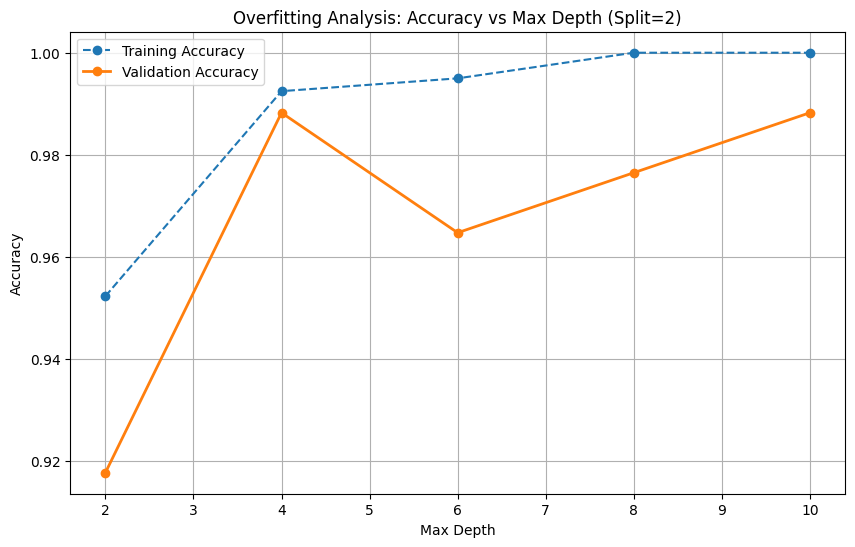


--- Feature Importance Ranking ---
Rank  Feature Name                   Importance Score
-------------------------------------------------------
1     worst texture                  2.0093
2     worst perimeter                0.5969
3     worst radius                   0.4880
4     worst concave points           0.3299
5     worst area                     0.2920
6     area error                     0.0249

--- Final Performance Metrics (Test Set) ---
Class 0 (Malignant): Precision=0.867, Recall=0.812, F1=0.839
Class 1 (Benign)   : Precision=0.893, Recall=0.926, F1=0.909

--- Confusion Matrix Analysis (Malignant as Positive) ---
True Positives (Cancer detected): 26
False Negatives (Cancer missed):  6  <-- Critical number
False Positives (False alarm):    4
True Negatives (Healthy cleared): 50


In [19]:
#Plottings
import matplotlib.pyplot as plt

# --- Extract data for plotting ---
# We want to see how Depth affects accuracy, so let's pick one split size (e.g., 2)
fixed_split = 2 
depths = []
train_accs = []
val_accs = []

for result in history:
    if result['min_samples_split'] == fixed_split:
        depths.append(result['max_depth'])
        train_accs.append(result['train_accuracy'])
        val_accs.append(result['validation accuracy'])

# --- Create the Plot ---
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accs, label='Training Accuracy', marker='o', linestyle='--')
plt.plot(depths, val_accs, label='Validation Accuracy', marker='o', linewidth=2)

plt.title(f'Overfitting Analysis: Accuracy vs Max Depth (Split={fixed_split})')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Feature Importance Analysis ---
print("\n--- Feature Importance Ranking ---")

# 1. Get the dictionary from your trained model
importances = final_model.feature_importances

# 2. Convert indices to names (using data.feature_names)
feature_names = data.feature_names
sorted_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)

# 3. Print Top 10
print(f"{'Rank':<5} {'Feature Name':<30} {'Importance Score':<15}")
print("-" * 55)
for i, (feat_idx, score) in enumerate(sorted_features[:10]):
    print(f"{i+1:<5} {feature_names[feat_idx]:<30} {score:.4f}")

print("\n--- Final Performance Metrics (Test Set) ---")

# A. Metrics for Class 0 (Malignant)
prec0, rec0, f1_0 = calculate_metrics(y_test, test_predictions, positive_class=0)
print(f"Class 0 (Malignant): Precision={prec0:.3f}, Recall={rec0:.3f}, F1={f1_0:.3f}")

# B. Metrics for Class 1 (Benign)
prec1, rec1, f1_1 = calculate_metrics(y_test, test_predictions, positive_class=1)
print(f"Class 1 (Benign)   : Precision={prec1:.3f}, Recall={rec1:.3f}, F1={f1_1:.3f}")

# C. Confusion Matrix Details
tp = np.sum((test_predictions == 0) & (y_test == 0)) # Malignant correctly identified
tn = np.sum((test_predictions == 1) & (y_test == 1)) # Benign correctly identified
fp = np.sum((test_predictions == 0) & (y_test == 1)) # Benign labeled as Malignant
fn = np.sum((test_predictions == 1) & (y_test == 0)) # Malignant labeled as Benign (Dangerous!)

print("\n--- Confusion Matrix Analysis (Malignant as Positive) ---")
print(f"True Positives (Cancer detected): {tp}")
print(f"False Negatives (Cancer missed):  {fn}  <-- Critical number")
print(f"False Positives (False alarm):    {fp}")
print(f"True Negatives (Healthy cleared): {tn}")

### C5.Tree complexity ~ Bias-Variance Analysis

The graph above illustrates the trade-off between bias and variance as tree complexity increases:

1.  **High Bias (Underfitting) at Depth 2:**
    At the lowest depth (2), both training and validation accuracies are lower (~91.7%). The model is too simple to capture the underlying patterns in the data, resulting in high bias.

2.  **Optimal Trade-off at Depth 4:**
    The model achieves its peak performance on the validation set (98.82%) at Depth 4. This represents the best spot where the model is complex enough to learn the signal (low bias) but not so complex that it memorizes noise. BUT despite this being the optimal point, the drop to 88.37% on the final unseen test set indicates that some generalization error remains.*

3.  **High Variance (Overfitting) at Depth 10:**
    As the depth increases to 10, the training accuracy reaches a perfect 1.0 (100%), indicating zero bias on the training data. However, the validation accuracy drops compared to Depth 4. This divergence—where the model memorizes the training data perfectly but performs worse on validation data—demonstrates high variance. The model has overfitted by learning noise specific to the training set.